In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import numpy as np
import math
import torch
import pickle as pkl
from tqdm import tqdm
from HPA_CC.data.dataset import DatasetFS
from HPA_CC.utils.pseudotime import intensities_to_pseudotime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from config import FUCCI_DS_PATH, FUCCI_NAME, OUTPUT_DIR
from multiprocessing import Pool
from argparse import ArgumentParser
from dataset_summary import load_microscopes_wells
import numpy as np

import matplotlib.pyplot as plt

fucci_ds = DatasetFS(FUCCI_DS_PATH)

# Generate the number of cells, raw intensities, standardized intensities, pseudotime, and angular distributions for each well

In [2]:
def process_well(well):
    sc_images = torch.load(well / f"images_{FUCCI_NAME}.pt") # Cells x Channels x H x W
    nuclei_masks = torch.load(well / f"nuclei_masks_{FUCCI_NAME}.pt") # Cells x H x W
    sc_nuclei = sc_images * nuclei_masks[:, None]
    mean_intensities = torch.sum(sc_nuclei[:, 2:], dim=(2, 3)) / torch.sum(nuclei_masks[:, None], dim=(2, 3)) # only calculating for GMNN and CDT1
    min_nonzero_GMNN = torch.min(mean_intensities[:, 0][mean_intensities[:, 0] > 0])
    min_nonzero_CDT1 = torch.min(mean_intensities[:, 1][mean_intensities[:, 1] > 0])
    log_mean_GMNN = torch.log(mean_intensities[:, 0] + min_nonzero_GMNN)
    log_mean_CDT1 = torch.log(mean_intensities[:, 1] + min_nonzero_CDT1)
    log_mean_fucci_intensities = torch.stack((log_mean_GMNN, log_mean_CDT1), dim=1)
    fucci_time, raw_time, well_std_int = intensities_to_pseudotime(log_mean_fucci_intensities.numpy())
    raw_time = raw_time * 2 * np.pi - np.pi
    return len(sc_images), log_mean_fucci_intensities, well_std_int, fucci_time, raw_time

# plot a grid of the polar distrbution for each well
n_wells = len(fucci_ds.well_list)
if (OUTPUT_DIR / f"well_intensity_cache_{FUCCI_NAME}.pkl").exists():
    cells_per_well, well_intensities, well_std_int, well_pseudotimes, well_angles = pkl.load(open(OUTPUT_DIR / f"well_intensity_cache_{FUCCI_NAME}.pkl", "rb"))
else:
    with Pool(16) as pool:
        # results = list(tqdm(pool.imap(process_well, fucci_ds.well_list), total=n_wells, desc="Plotting Pseudotime distributions"))
        from HPA_CC.data.img_stats import well_fucci_stats
        paths = []
        for well in tqdm(fucci_ds.well_list):
            paths.append((well / f"images_{FUCCI_NAME}.pt", well / f"nuclei_masks_{FUCCI_NAME}.pt"))
        results = list(tqdm(pool.map(well_fucci_stats, paths), total=n_wells, desc="Plotting Pseudotime distributions"))

    # cells_per_well, well_intensities, well_std_int, well_pseudotimes, well_angles = zip(*results)
    scope_names, cells_per_well, well_intensities, well_std_int, well_pseudotimes, well_angles = zip(*results)
    pkl.dump((cells_per_well, well_intensities, well_std_int, well_pseudotimes, well_angles), open(OUTPUT_DIR / f"well_intensity_cache_{FUCCI_NAME}.pkl", "wb"))
print(np.min(np.concatenate(well_std_int)), np.max(np.concatenate(well_std_int)))

100%|██████████| 136/136 [00:00<00:00, 119711.51it/s]


/home/ishang/miniconda3/envs/hpa-cc/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/ishang/miniconda3/envs/hpa-cc/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/ishang/miniconda3/envs/hpa-cc/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/ishang/miniconda3/envs/hpa-cc/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/ishang/miniconda3/envs/hpa-cc/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/ishang/miniconda3/envs/hpa-cc/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarnin

-1.827689321892786 1.0003386674636296


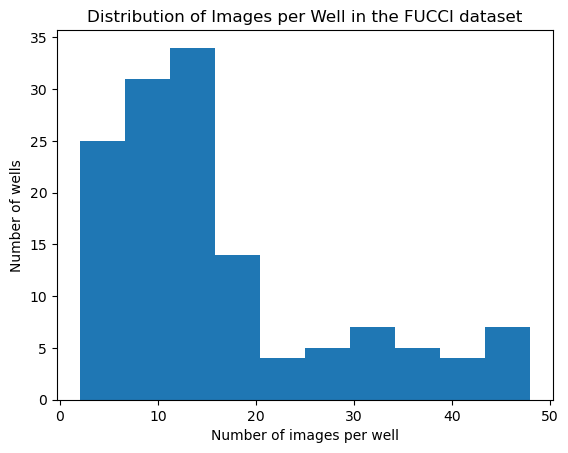

In [3]:
images_per_well = [len(fucci_ds.images_in_well(well)) for well in fucci_ds.well_list]
plt.hist(images_per_well)
plt.savefig(OUTPUT_DIR / "images_per_well.png")
plt.xlabel("Number of images per well")
plt.ylabel("Number of wells")
plt.title(f"Distribution of Images per Well in the FUCCI dataset")
plt.show()

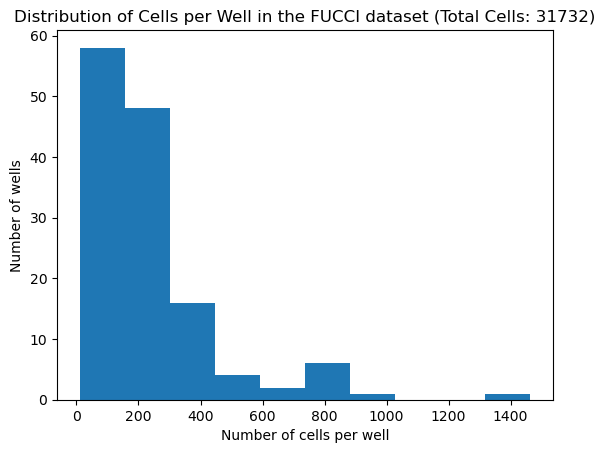

chamber--U01--V04


In [4]:
total_cells = np.sum(cells_per_well)
plt.hist(cells_per_well)
plt.xlabel("Number of cells per well")
plt.ylabel("Number of wells")
plt.title(f"Distribution of Cells per Well in the FUCCI dataset (Total Cells: {total_cells})")
plt.show()
plt.close()

microscopes, wells = load_microscopes_wells()
print(wells[np.argmax(cells_per_well)])

Plotting Pseudotime Colors: 100%|██████████| 136/136 [00:06<00:00, 20.93it/s]


<Figure size 640x480 with 0 Axes>

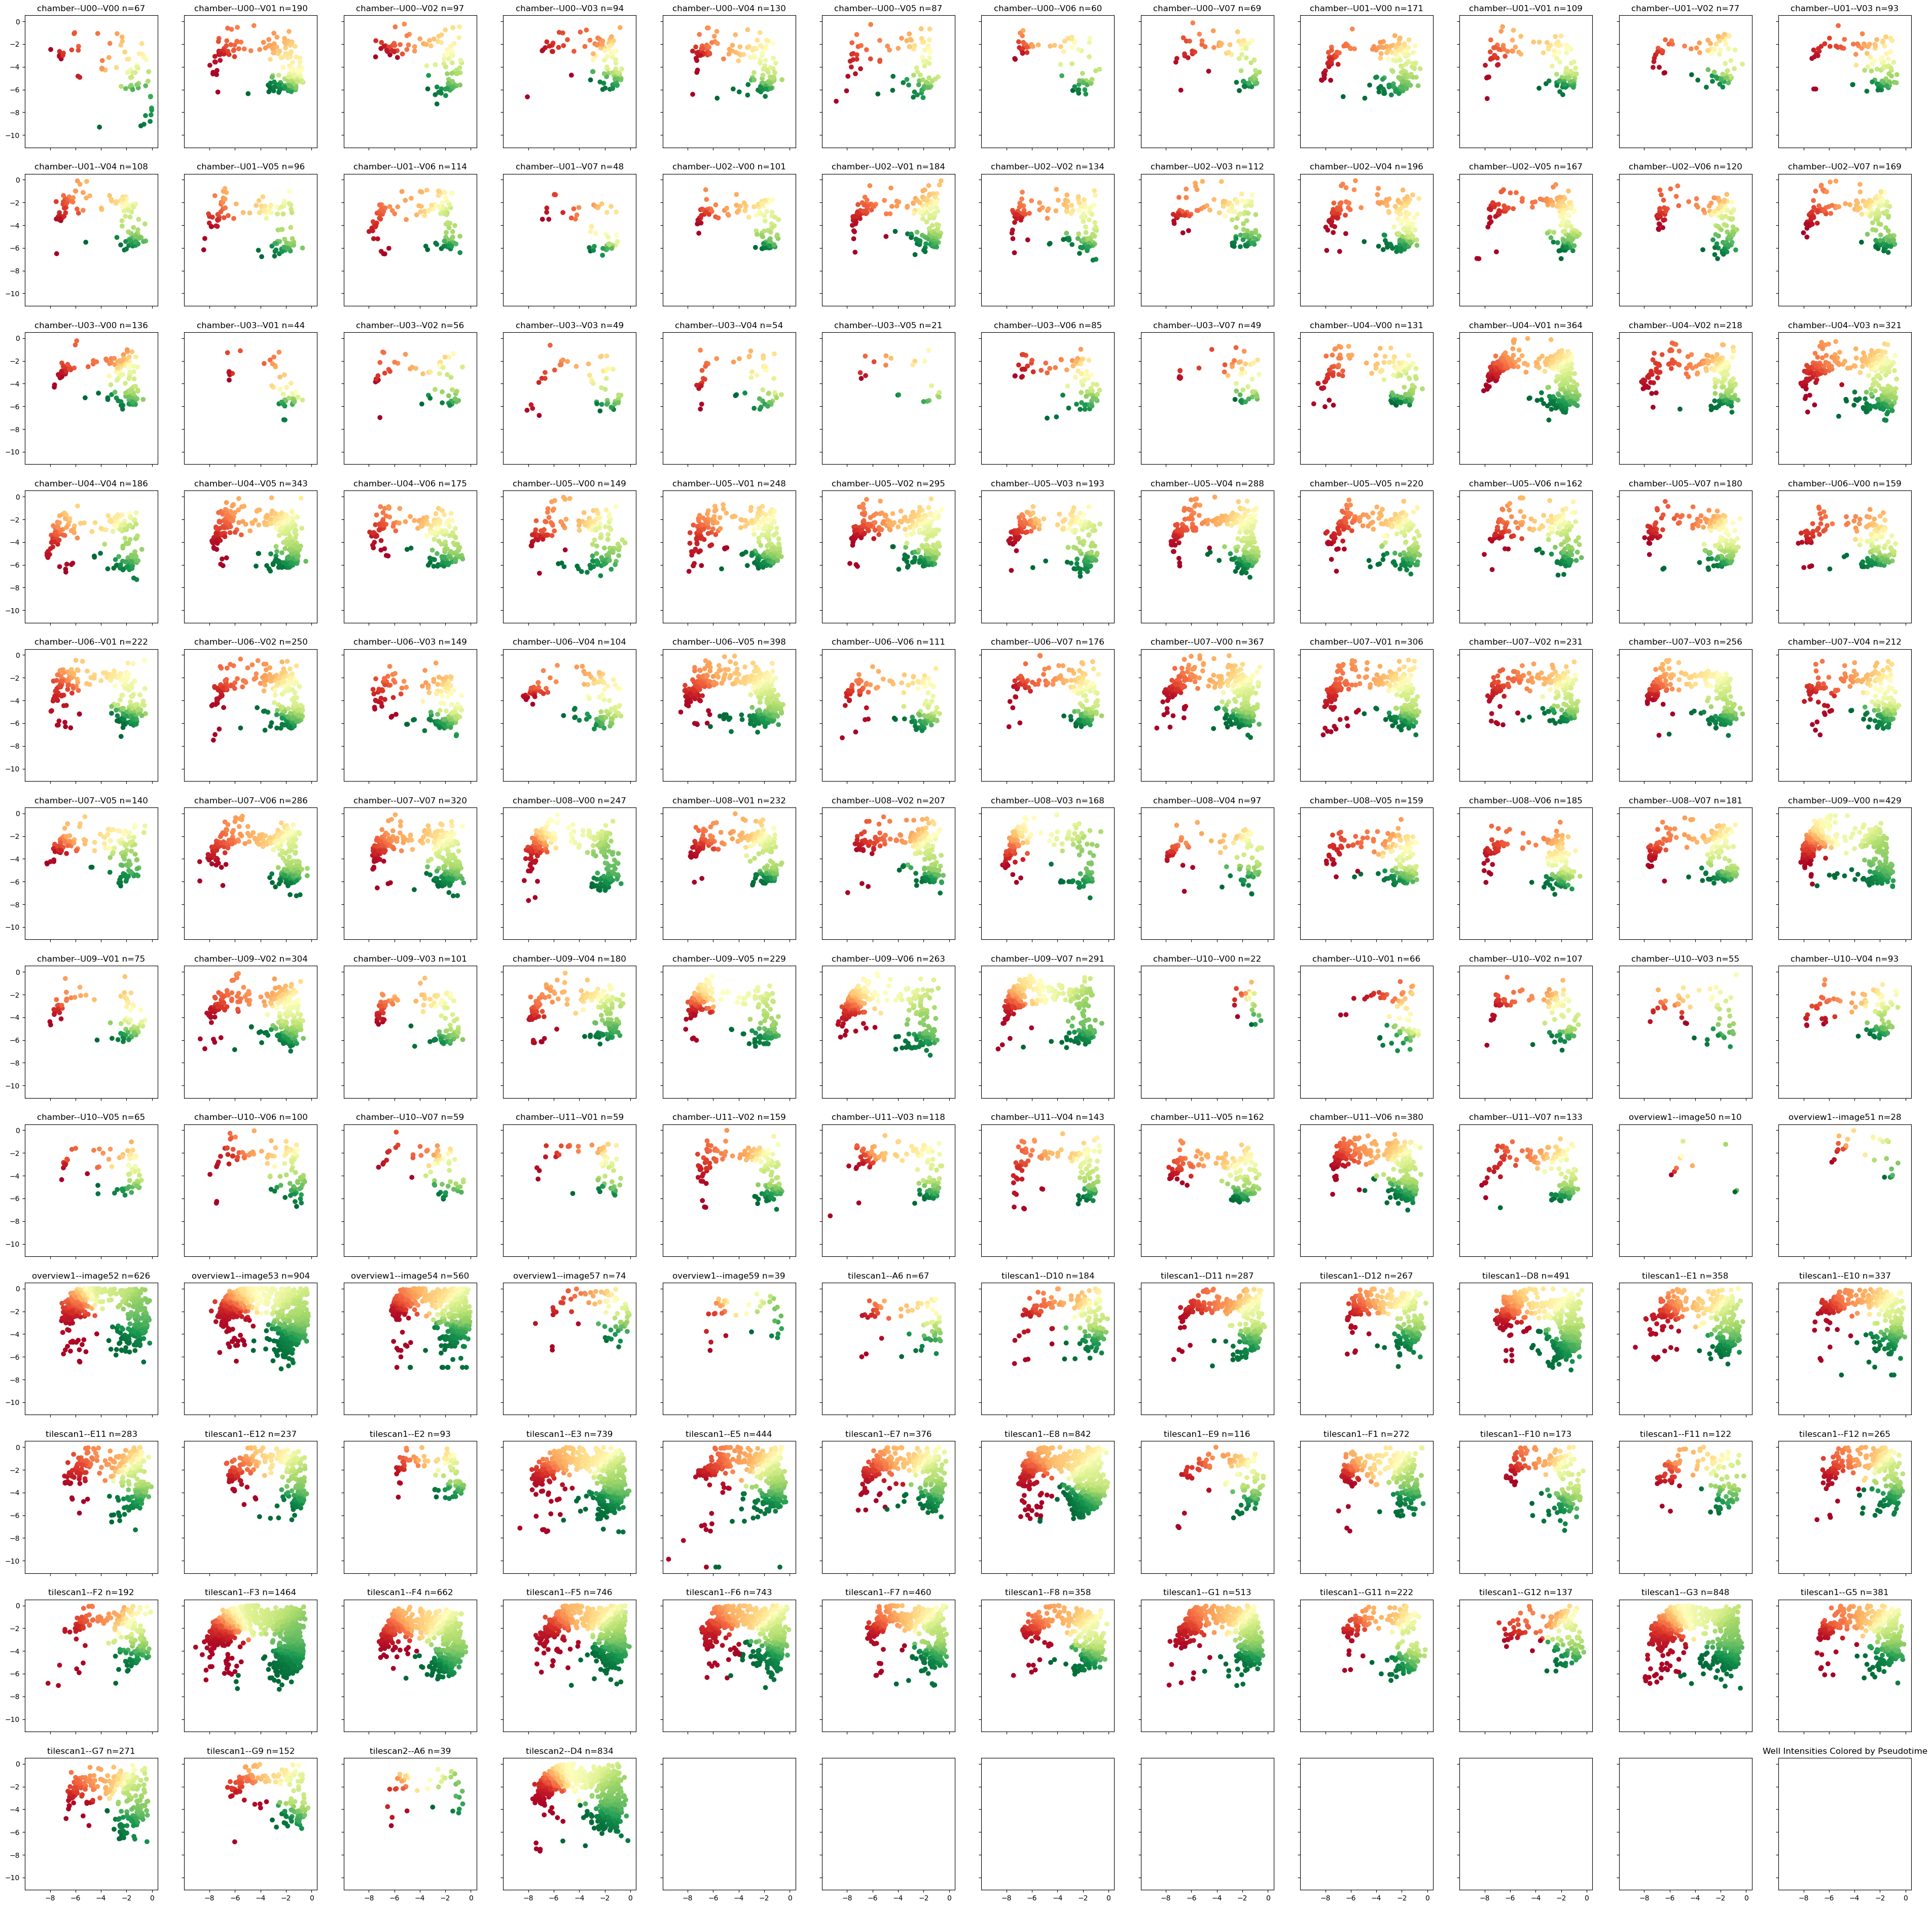

In [5]:
n_col = 12
n_row = math.ceil(n_wells / n_col)
plt.clf()
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col * 4, n_row * 4), sharex=True, sharey=True)
for i, well, cells, intensities, pseudotime in tqdm(zip(range(n_wells), fucci_ds.well_list, cells_per_well, well_intensities, well_pseudotimes), total=n_wells, desc="Plotting Pseudotime Colors"):
    ax = axes[i // n_col, i % n_col]
    ax.set_title(f"{well.name} n={cells}")
    ax.scatter(intensities[:, 0], intensities[:, 1], c=pseudotime, cmap="RdYlGn")
plt.title("Well Intensities Colored by Pseudotime")
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

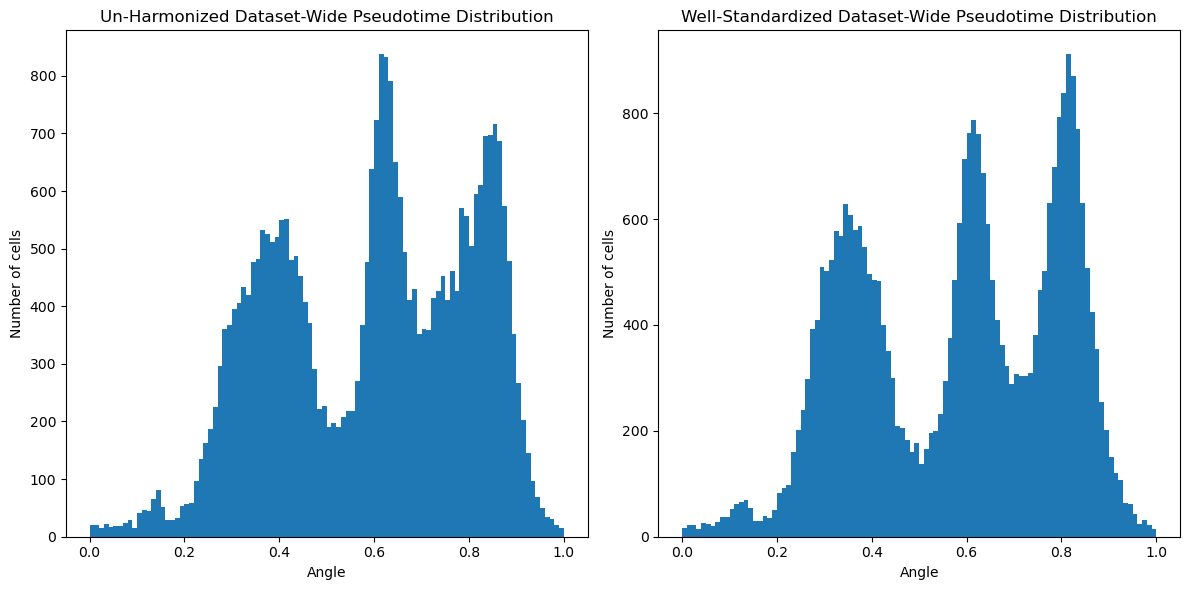

<Figure size 640x480 with 0 Axes>

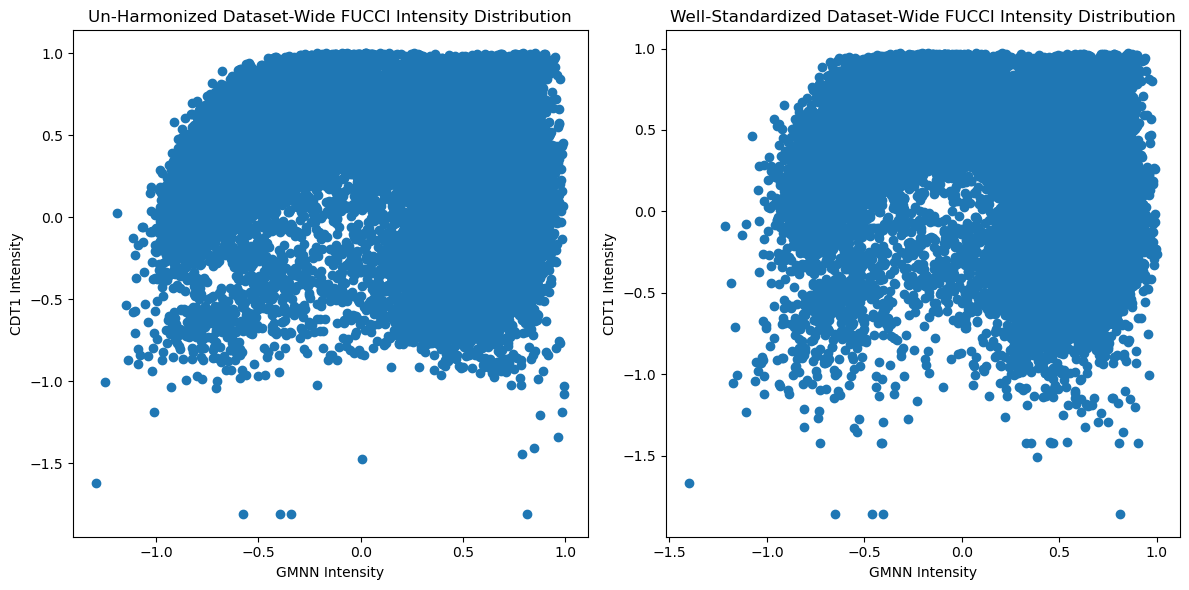

In [6]:
full_time, full_angles, full_std_int = intensities_to_pseudotime(np.concatenate(well_intensities), auto_start=True)
std_full_time, std_full_angles, std_full_std_int = intensities_to_pseudotime(np.concatenate(well_std_int), rescale=False, auto_start=True)

plt.clf()
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot for full_angles
axes[0].hist(full_angles, bins=100)
axes[0].set_xlabel("Angle")
axes[0].set_ylabel("Number of cells")
axes[0].set_title("Un-Harmonized Dataset-Wide Pseudotime Distribution")

# Plot for std_full_angles
axes[1].hist(std_full_angles, bins=100)
axes[1].set_xlabel("Angle")
axes[1].set_ylabel("Number of cells")
axes[1].set_title("Well-Standardized Dataset-Wide Pseudotime Distribution")

plt.tight_layout()
plt.show()
plt.close()

plt.clf()
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot for std_int
axes[0].scatter(full_std_int[:, 0], full_std_int[:, 1])
axes[0].set_xlabel("GMNN Intensity")
axes[0].set_ylabel("CDT1 Intensity")
axes[0].set_title("Un-Harmonized Dataset-Wide FUCCI Intensity Distribution")

axes[1].scatter(std_full_std_int[:, 0], std_full_std_int[:, 1])
axes[1].set_xlabel("GMNN Intensity")
axes[1].set_ylabel("CDT1 Intensity")
axes[1].set_title("Well-Standardized Dataset-Wide FUCCI Intensity Distribution")

plt.tight_layout()
plt.show()
plt.close()

/home/ishang/miniconda3/envs/hpa-cc/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[[0.60922118]
 [0.80992918]
 [0.3266259 ]
 [0.40145936]
 [0.12060039]
 [0.65338067]
 [0.8304107 ]]
[4 2 3 0 5 1 6]
[0.12060039 0.3266259  0.40145936 0.60922118 0.65338067 0.80992918
 0.8304107 ]
[2, 3, 1, 1, 0, 2, 3]


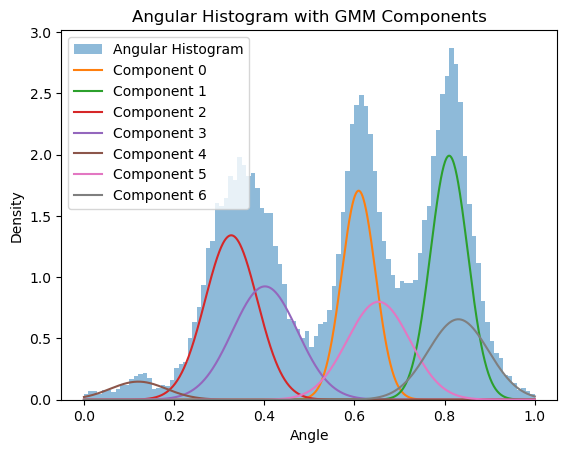

In [7]:
from sklearn.mixture import BayesianGaussianMixture

# Fit the Bayesian GMM to the angular distributions
gmm = BayesianGaussianMixture(n_components=7, covariance_type='full', n_init=10)
gmm.fit(std_full_angles.reshape(-1, 1))

# Get the predicted labels for each data point
labels = gmm.predict(std_full_angles.reshape(-1, 1))
# Plot the angular histogram
plt.hist(std_full_angles, bins=100, density=True, alpha=0.5, label='Angular Histogram')

# Plot the GMM components
x = np.linspace(0, 1, 1000)
y = np.exp(gmm._estimate_weighted_log_prob(x.reshape(-1, 1)))
for i in range(gmm.n_components):
    plt.plot(x, y[:, i], label=f'Component {i}')

def full_comp_to_class(comp):
    sorted_idx = list(np.argsort(gmm.means_.flatten()))
    if sorted_idx.index(comp) == 0:
        return 0
    return ((sorted_idx.index(comp) - 1) // 2) + 1

print(gmm.means_)
print(np.argsort(gmm.means_.flatten()))
print(gmm.means_.flatten()[np.argsort(gmm.means_.flatten())])
print([full_comp_to_class(i) for i in range(gmm.n_components)])

plt.xlabel('Angle')
plt.ylabel('Density')
plt.title('Angular Histogram with GMM Components')
plt.legend()
plt.show()

Plotting Pseudotime Colors: 100%|██████████| 136/136 [00:06<00:00, 21.90it/s]


<Figure size 640x480 with 0 Axes>

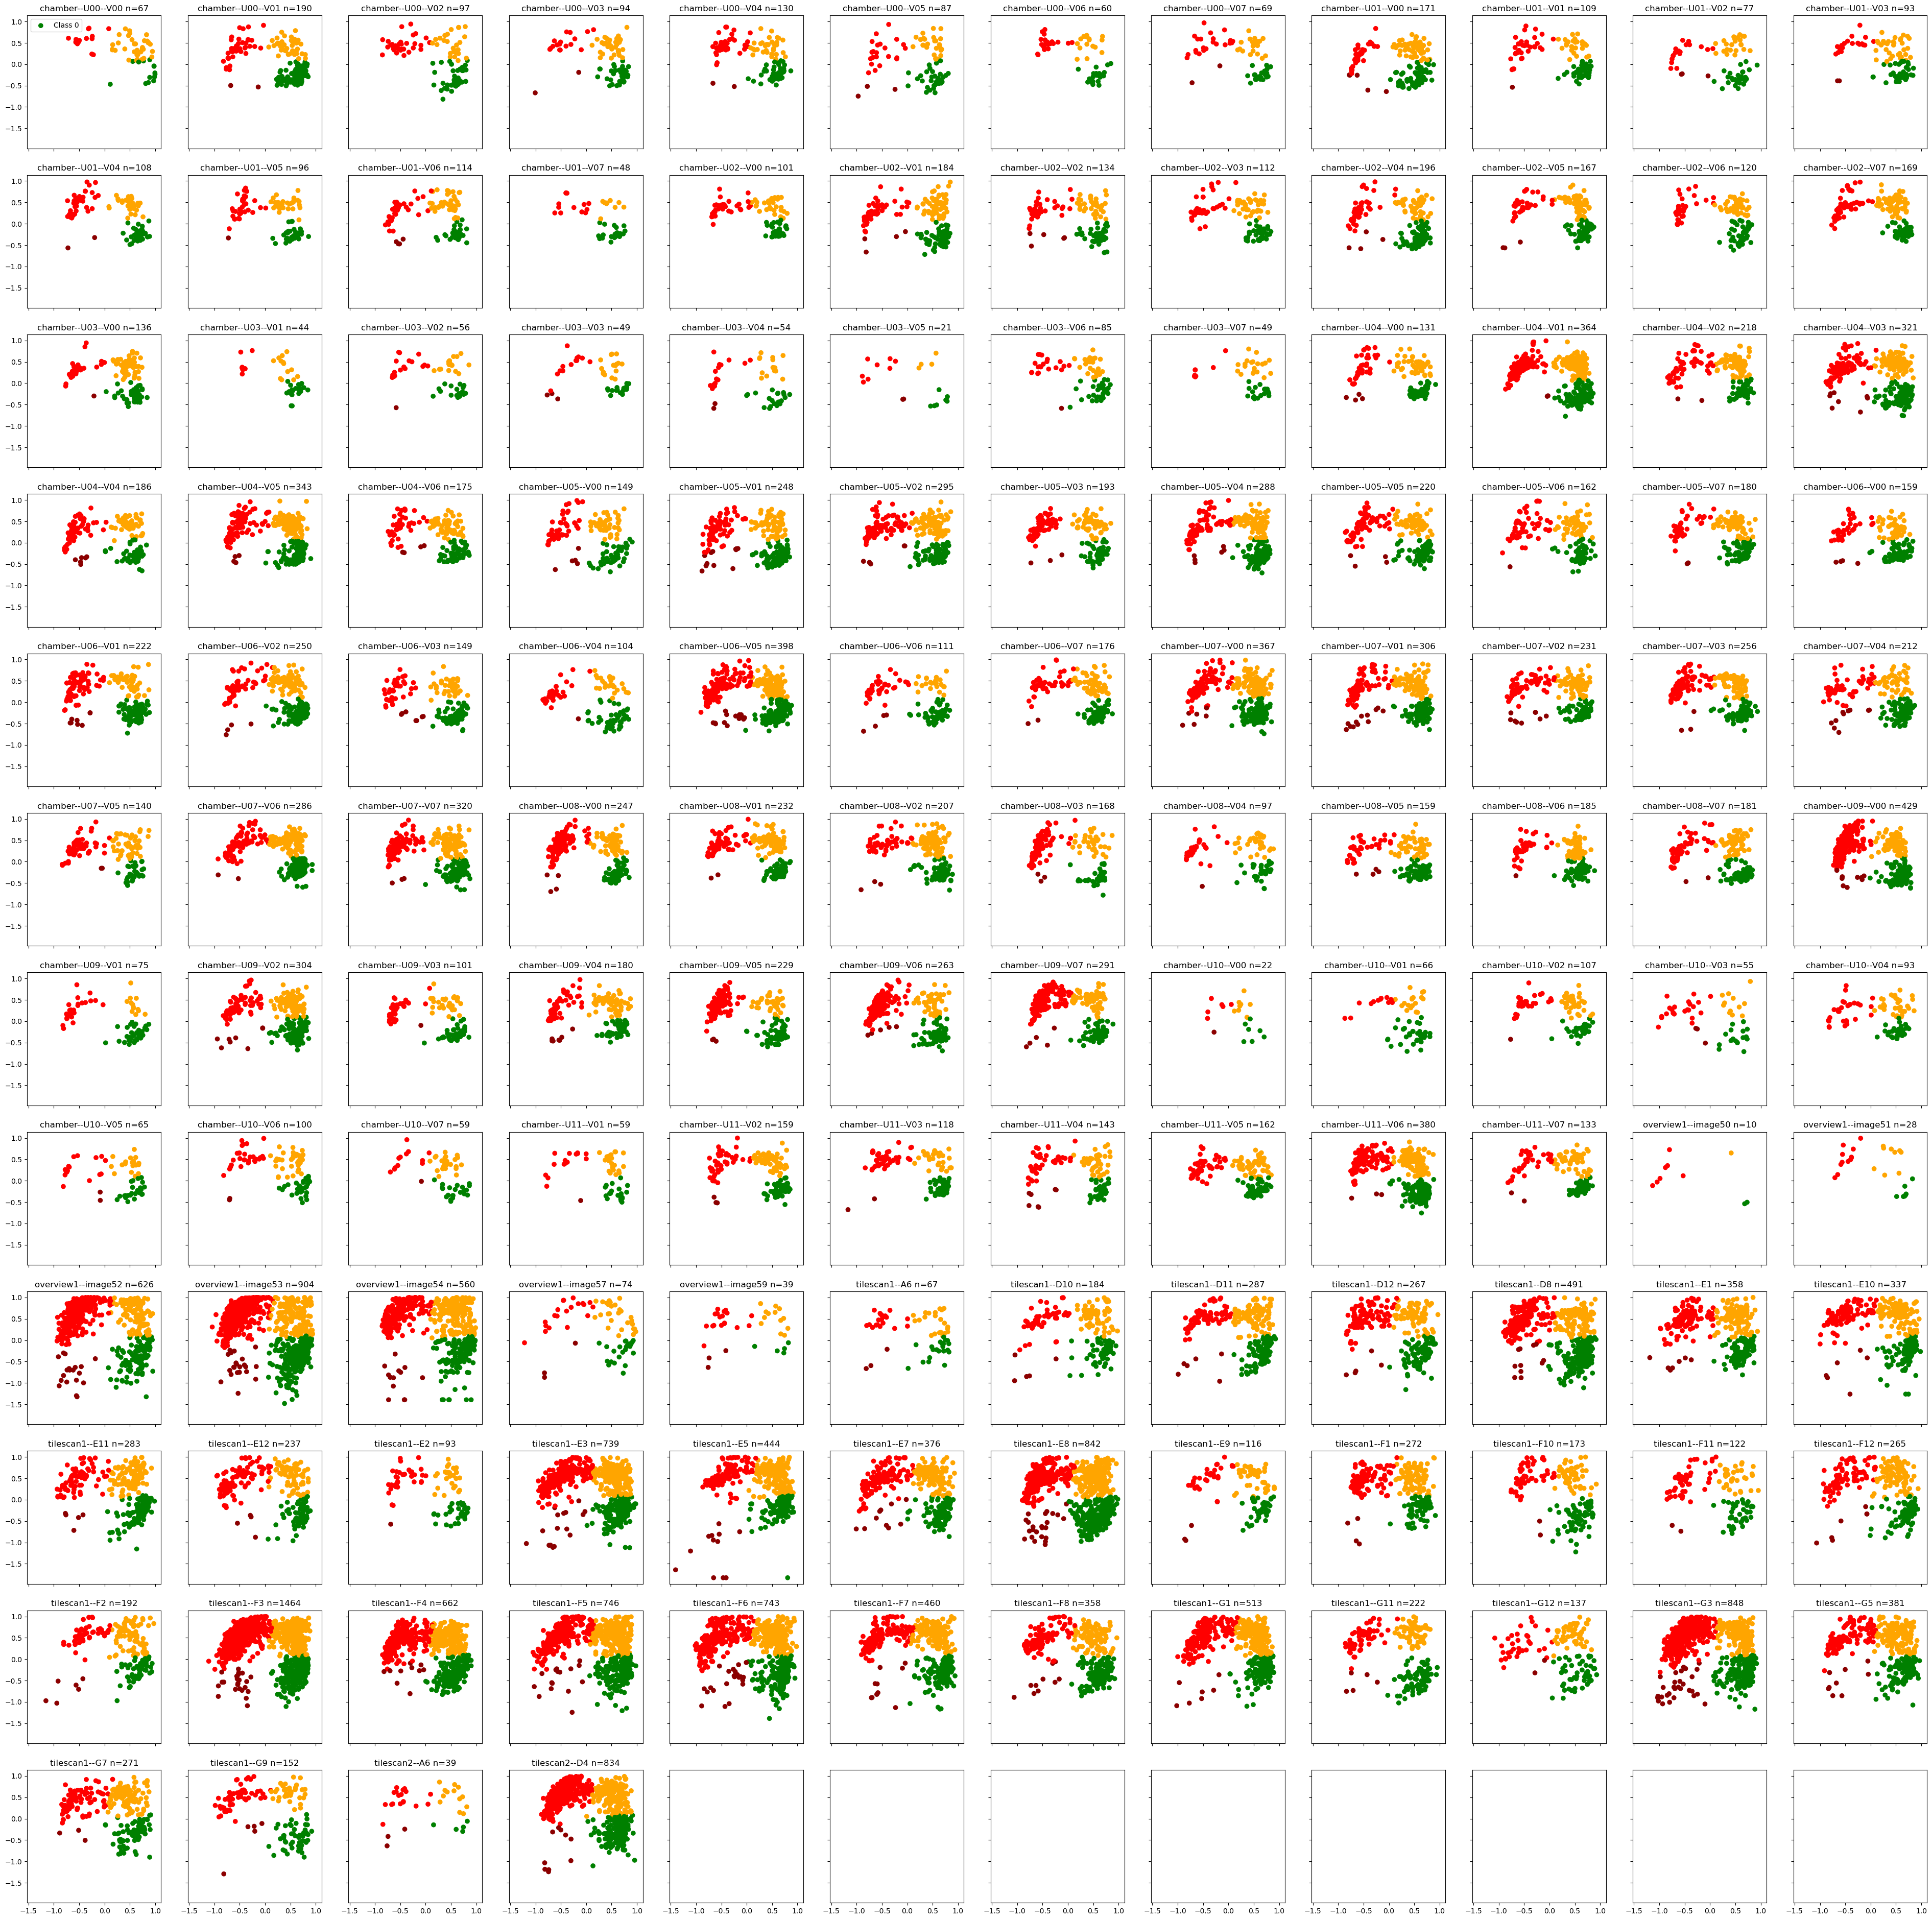

[  671 11438  9358 10265]
[0.02114585 0.36045632 0.29490735 0.32349048]
[0.83630555 0.04906111 0.05996591 0.05466742]


In [8]:
# test how good the fit is
# map the GMM components to desired labels
NUM_CLASSES = 4
# plot the intensity scatter plot colored by the GMM labels
n_col = 12
n_row = math.ceil(n_wells / n_col)
plt.clf()
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col * 4, n_row * 4), sharex=True, sharey=True)
cell_idx = 0
props = np.array([0, 0, 0, 0])
for i, well, n_cells, intensities in tqdm(zip(range(n_wells), fucci_ds.well_list, cells_per_well, well_std_int), total=n_wells, desc="Plotting Pseudotime Colors"):
    angles = std_full_angles[cell_idx:cell_idx + n_cells]
    cell_idx += n_cells
    class_likelihoods = np.zeros((n_cells, NUM_CLASSES))
    likelihoods = gmm._estimate_weighted_log_prob(angles.reshape(-1, 1))
    for comp in range(gmm.n_components):
        p = class_likelihoods[:, full_comp_to_class(comp)]
        class_likelihoods[:, full_comp_to_class(comp)] = np.log(np.exp(p) + np.exp(likelihoods[:, comp]))
    pseudotime_class = np.argmax(class_likelihoods, axis=1)
    ax = axes[i // n_col, i % n_col]
    ax.set_title(f"{well.name} n={n_cells}")
    color_map = {0: "darkred", 1: "red", 2: "orange", 3: "green"}
    colors = [color_map[i] for i in pseudotime_class]
    ax.scatter(intensities[:, 0], intensities[:, 1], c=colors)
    if i == 0:
        ax.legend([f"Class {i}" for i in range(NUM_CLASSES)])
    for i in range(len(props)):
        props[i] += np.sum(pseudotime_class == i)
plt.show()
plt.close()

print(props)
print(props / np.sum(props))
inv_props = 1 / props
print(inv_props / np.sum(inv_props))

In [9]:
print(props)
print(props / np.sum(props))
tot_props = np.array([props[0] + props[1], props[2], props[3]])
# inv_props = 1 / np.sqrt(props)
inv_props = 1 / tot_props
print(inv_props / np.sum(inv_props))

[  671 11438  9358 10265]
[0.02114585 0.36045632 0.29490735 0.32349048]
[0.28788472 0.37251508 0.3396002 ]


<Figure size 640x480 with 0 Axes>

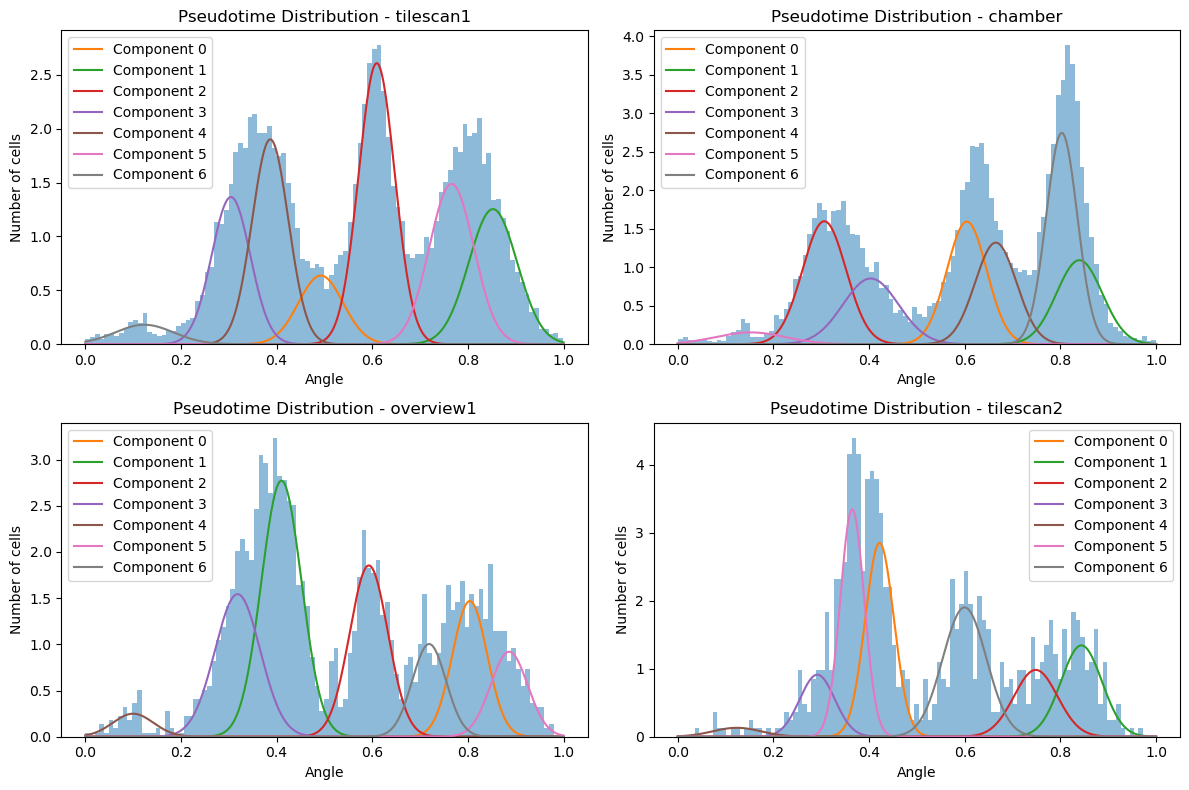

In [10]:
from sklearn.mixture import GaussianMixture
# plot the per-microscope splits of the angular distribution
plt.clf()
image_microscopes = []
for n_cells, microscope in zip(cells_per_well, fucci_ds.well_list):
    microscope = microscope.name.split("--")[0]
    for _ in range(n_cells):
        image_microscopes.append(microscope)
image_microscopes = np.array(image_microscopes)

# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Iterate over the unique microscopes and plot the distributions in separate axes
scope_gmms = {}
for i, scope in enumerate(set(image_microscopes)):
    mask = (image_microscopes == scope)
    ax = axes[i // 2, i % 2]
    ax.hist(std_full_angles[mask], bins=100, label=scope, alpha=0.5, density=True)

    # Fit the GMM to the angular distributions
    gmm = GaussianMixture(n_components=7, covariance_type='full', n_init=10)
    gmm.fit(std_full_angles[mask].reshape(-1, 1))
    scope_gmms[scope] = gmm
    
    handles = []
    x = np.linspace(0, 1, 1000)
    y = gmm._estimate_weighted_log_prob(x.reshape(-1, 1))
    for j in range(gmm.n_components):
        comp = ax.plot(x, np.exp(y[:, j]), label=f"Component {j}")
        handles.append(comp[0])

    ax.legend(handles=handles)

    ax.set_xlabel("Angle")
    ax.set_ylabel("Number of cells")
    ax.set_title(f"Pseudotime Distribution - {scope}")

plt.tight_layout()
plt.show()

Plotting Pseudotime Colors: 100%|██████████| 136/136 [00:06<00:00, 21.52it/s]


<Figure size 640x480 with 0 Axes>

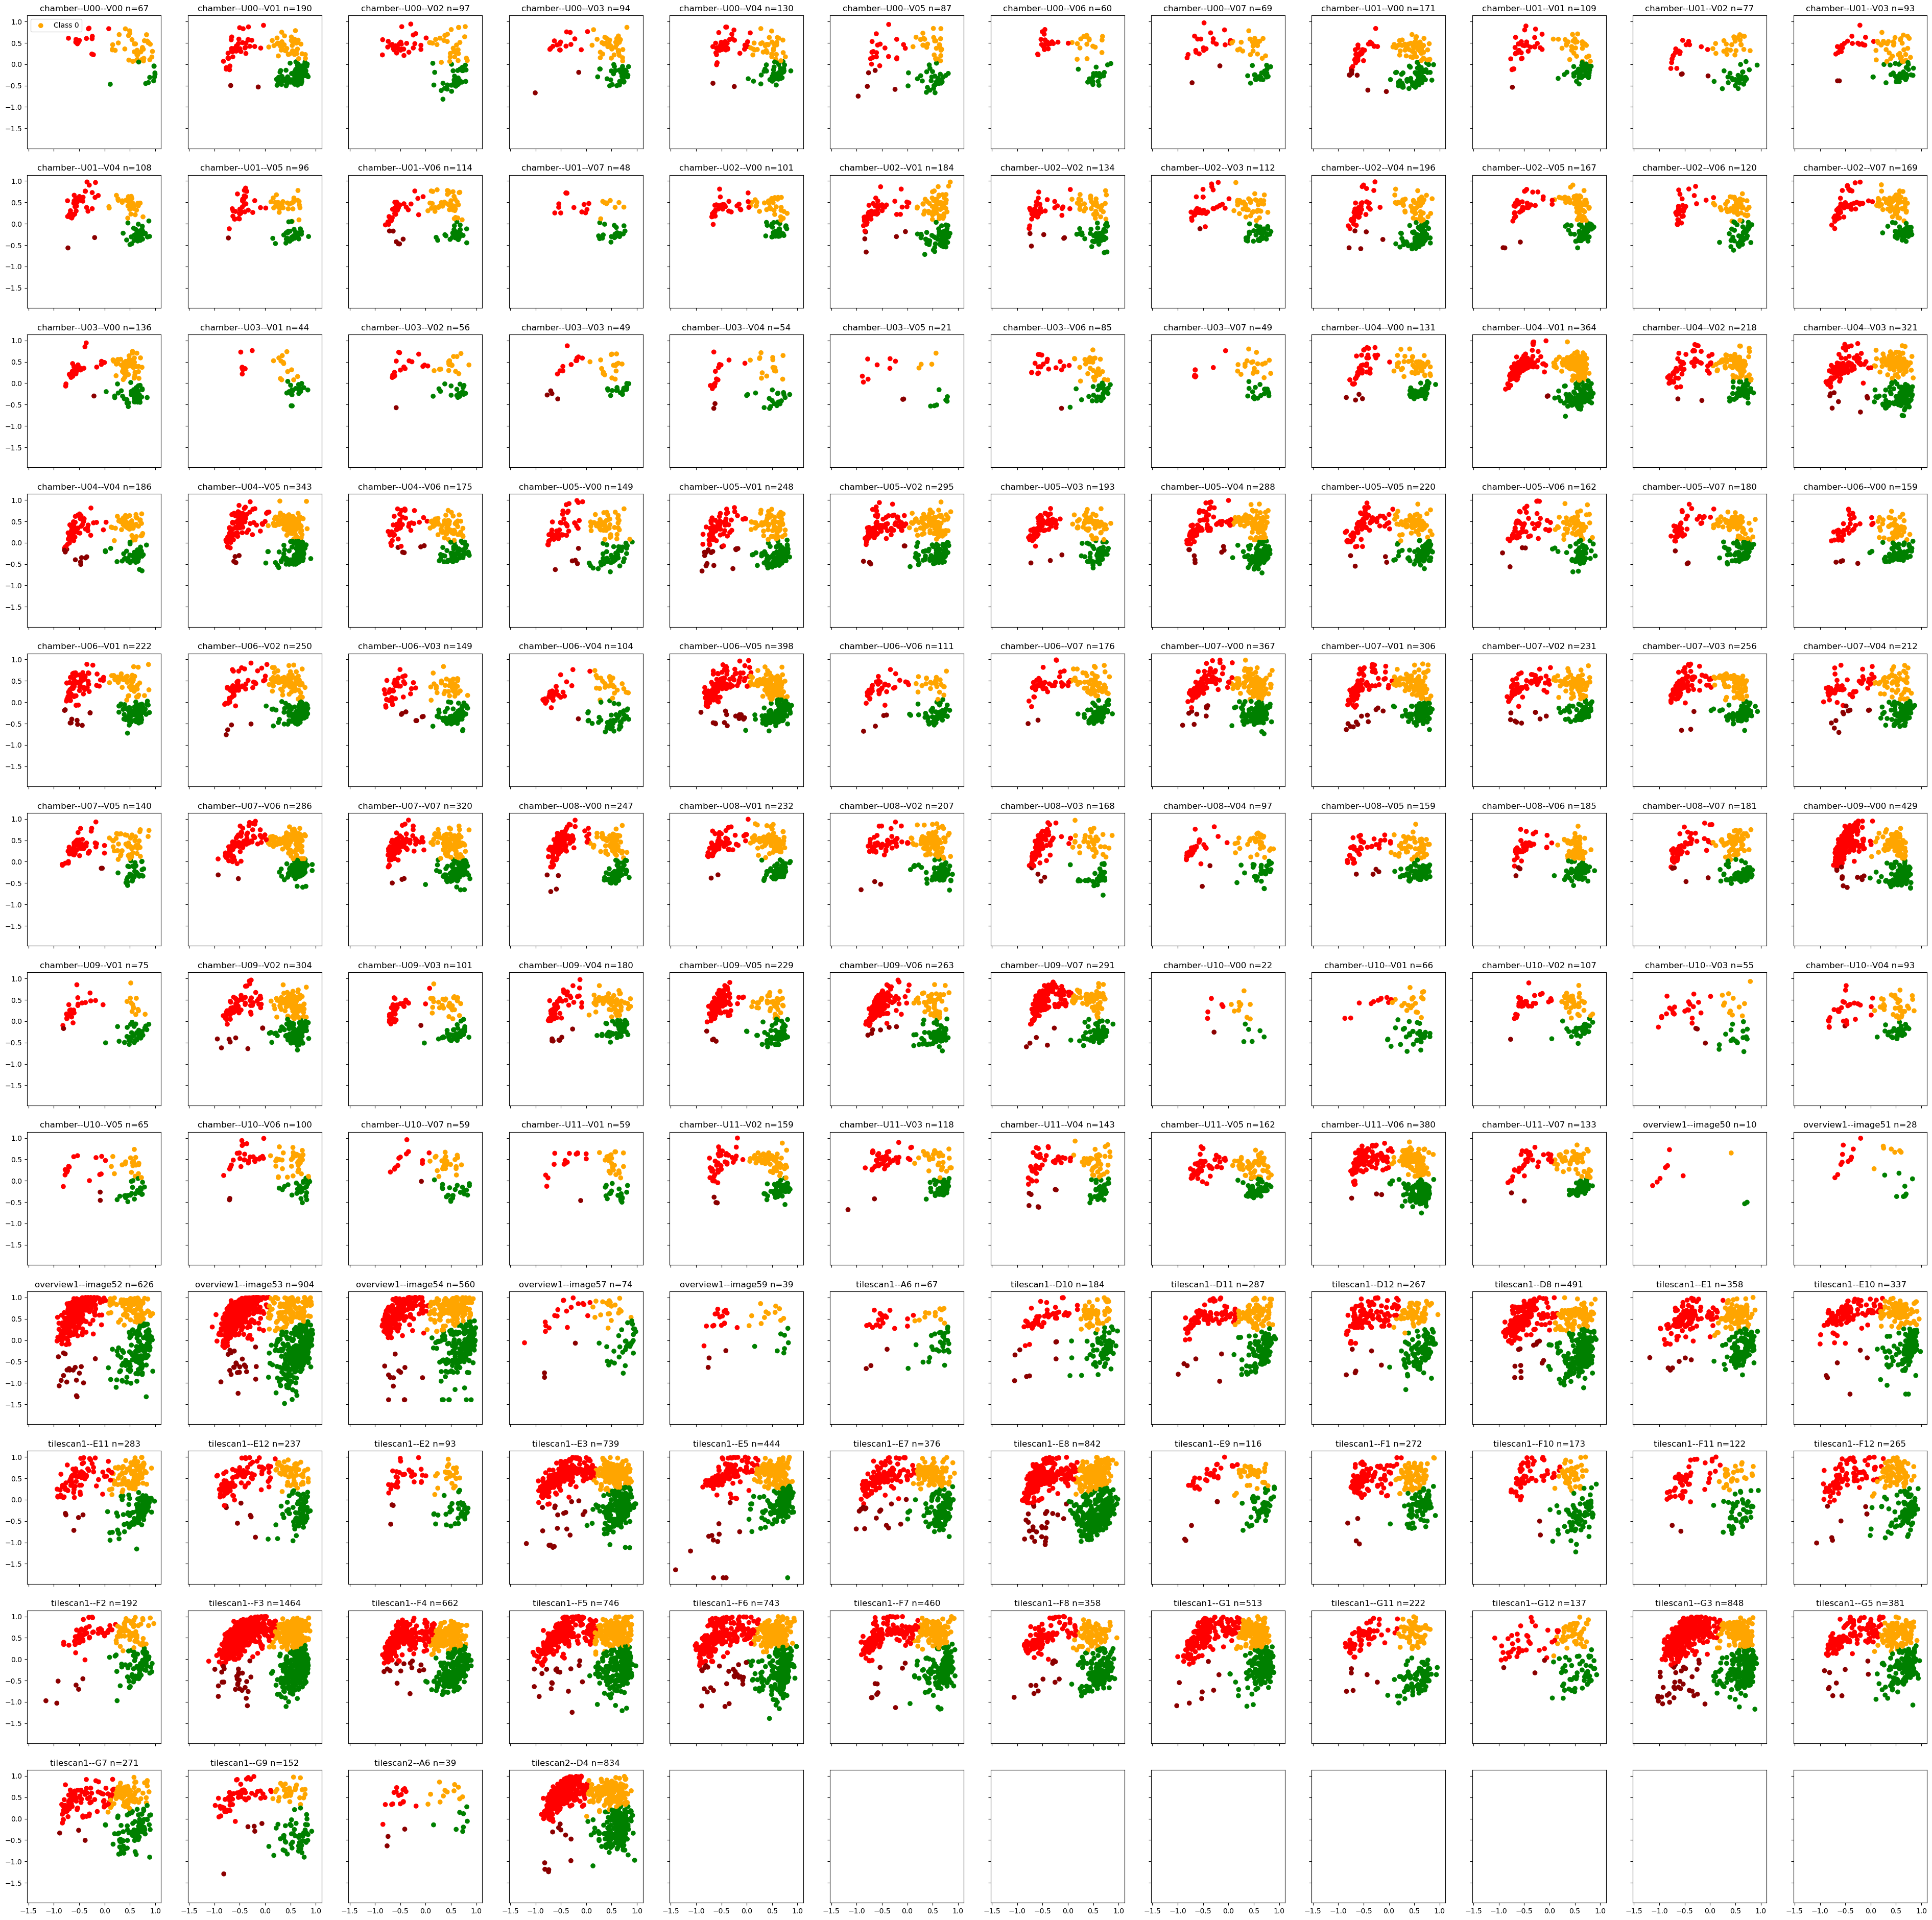

In [11]:
# plot the intensity scatter plot colored by the GMM labels
from HPA_CC.utils.pseudotime import comp_to_class
from config import OUTPUT_DIR

groupings = {
    "tilescan1": [0, 1, 1, 1, 2, 3, 3],
    "tilescan2": [0, 1, 1, 1, 2, 3, 3],
    "overview1": [0, 1, 1, 2, 3, 3, 3],
    "chamber": [0, 1, 1, 2, 2, 3, 3]
}

with open(OUTPUT_DIR / 'groupings.pkl', 'wb') as f:
    pkl.dump(groupings, f)

with open(OUTPUT_DIR / 'scope_gmms.pkl', 'wb') as f:
    pkl.dump(scope_gmms, f)

n_col = 12
n_row = math.ceil(n_wells / n_col)
plt.clf()
scope_props = {scope: np.zeros((NUM_CLASSES,)) for scope in groupings.keys()}
cell_idx = 0
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col * 4, n_row * 4), sharex=True, sharey=True)
for i, well, n_cells, intensities in tqdm(zip(range(n_wells), fucci_ds.well_list, cells_per_well, well_std_int), total=n_wells, desc="Plotting Pseudotime Colors"):
    scope = well.name.split("--")[0]
    angles = std_full_angles[cell_idx:cell_idx + n_cells]
    cell_idx += n_cells
    class_likelihoods = np.zeros((n_cells, NUM_CLASSES))
    likelihoods = scope_gmms[scope]._estimate_weighted_log_prob(angles.reshape(-1, 1))
    for comp in range(scope_gmms[scope].n_components):
        p = class_likelihoods[:, comp_to_class(comp, scope_gmms[scope], groupings[scope])]
        class_likelihoods[:, comp_to_class(comp, scope_gmms[scope], groupings[scope])] = np.log(np.exp(p) + np.exp(likelihoods[:, comp]))
    pseudotime_class = np.argmax(class_likelihoods, axis=1)
    ax = axes[i // n_col, i % n_col]
    ax.set_title(f"{well.name} n={n_cells}")
    colors = [color_map[i] for i in pseudotime_class]
    ax.scatter(intensities[:, 0], intensities[:, 1], c=colors)
    if i == 0:
        ax.legend([f"Class {i}" for i in range(NUM_CLASSES)])
    for i in range(NUM_CLASSES):
        scope_props[scope][i] += np.sum(pseudotime_class == i)

In [12]:
tot_props = np.sum(np.stack([scope_props[scope] for scope in scope_props.keys()]), axis=0)
print(tot_props / np.sum(tot_props))
for scope, props in scope_props.items():
    print(scope, np.sum(props) / np.sum(tot_props))
    print(props / np.sum(props))


[0.02410816 0.35998361 0.27543174 0.34047649]
tilescan1 0.41289549981091644
[0.02633186 0.38841398 0.25415967 0.33109449]
tilescan2 0.027511660153787976
[0.01603666 0.51088202 0.2187858  0.25429553]
overview1 0.07062271524013614
[0.02677376 0.47211066 0.1869701  0.31414547]
chamber 0.48897012479515944
[0.02229956 0.31129157 0.30935808 0.35705079]
